### Clustering

Clustering is a type of unsupervised learning that involves grouping similar data points together based on their characteristics. The goal of clustering is to find natural groupings in the data that can help us understand patterns, relationships, and structure that may not be immediately obvious from a simple inspection of the data.

There are many different clustering algorithms, each with its own strengths and weaknesses. Some of the most popular clustering algorithms include KMeans, DBSCAN, Agglomerative Clustering, and Spectral Clustering. In this report, we will be focussing on KMeans, its variants and compare it against Spectral Clustering.

## KMeans

Kmeans is a popular unsupervised clustering algorithm that partitions data into K clusters, where K is a predefined number of clusters. The algorithm iteratively assigns each data point to its nearest centroid and then updates the centroids based on the mean of the points assigned to them. This process continues until the centroids no longer move significantly.

The time complexity of the KMeans algorithm is O(KnI*d), where n is the number of data points, d is the dimensionality of the data, K is the number of clusters, and I is the number of iterations. The running time of the algorithm depends on the initialization of the centroids and the convergence criteria.

KMeans++ is a variant of KMeans that improves the initialization of the centroids. Instead of randomly selecting the initial centroids, KMeans++ selects them based on the distance to the existing centroids. This helps to ensure that the initial centroids are well spread out and can lead to better clustering results.

The time complexity of the KMeans++ algorithm is the same as KMeans, O(KnI*d), but it typically converges faster than KMeans.


### KMeans Algorithm
1. Initialize K centroids randomly
2. Repeat until convergence:
   a. Assign each data point to the nearest centroid
   b. Update each centroid as the mean of the data points assigned to it
3. Return the final centroids and cluster assignments


### KMeans++ Algorithm
1. Choose the first centroid randomly from the data points
2. Repeat until K centroids have been chosen:
   a. For each data point, compute the distance to the nearest centroid
   b. Choose the next centroid randomly from the data points with probability proportional to the squared distance
3. Assign each data point to the nearest centroid
4. Update each centroid as the mean of the data points assigned to it
5. Repeat steps 3 and 4 until convergence
6. Return the final centroids and cluster assignments




Let us take a look at this algorithm in action

In [1]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from typing import Mapping

from PIL import Image
%matplotlib inline
import seaborn as sns; sns.set()  # for plot styling
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Custom implementation of k-means and k-means++
def kmeans(X:np.ndarray, k=5, centroids=None, tolerance=1e-2, seed=42) -> (np.ndarray, Mapping[int,list]):
    """ 
    Returns centroids and list of row indexes for each cluster for given dataset and no of clusters 
    """
    if centroids == 'kmeans++':
        ## Kmeans++ algorithm for initial centroid identification
        ## pick first centroid randomly, pick next centroid where 
        ## minimum distance to the previous clusters is maximized
        first_centroid_idx = np.random.choice(X.shape[0], 1, replace=False)
        first_centroid = X[first_centroid_idx]
        dist = np.zeros((X.shape[0], k))
        dist[:] = np.nan ## setting all elements to nan for easier row wise minimum calculation
        init_centroids = first_centroid
        for j in range(k-1):
            dist[:, j] = np.linalg.norm(X - first_centroid, axis = 1)
            min_dist = np.nanmin(dist, axis = 1, keepdims = True)
            next_centroid_idx = np.argmax(min_dist, axis = 0)
            next_centroid = X[next_centroid_idx]
            init_centroids = np.concatenate((init_centroids, next_centroid), axis = 0)
            first_centroid = next_centroid
    else:
        ## Pick k elements randomly as the initial centroids
        X_unique = np.unique(X, axis=0)
        init_centroids_idx = np.random.choice(X_unique.shape[0], k, replace=False)
        init_centroids = X_unique[init_centroids_idx]
    while True:
        cluster_record_map = [[] for _ in range(k)]
        for i in range(X.shape[0]):
            cluster = np.argmin(np.linalg.norm(X[i] - init_centroids, axis=1))
            cluster_record_map[cluster].append(i)
        next_centroids = np.array([np.mean(X[cluster_record_map[j]], axis=0) for j in range(k)])
        dist_bw_centroids = np.all(np.linalg.norm(init_centroids - next_centroids, axis=1))
        if np.any(dist_bw_centroids) >= tolerance:
            init_centroids = next_centroids
        else:
            return next_centroids, cluster_record_map

Lets demonstrate it with some synthesised data.

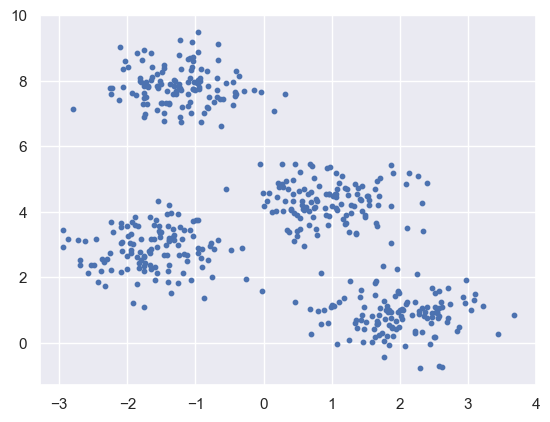

In [3]:
X, y_true = make_blobs(n_samples=500, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=10);

Visually, we see that the generated data has 4 clusters. Now lets see that kmeans tells us.

A visual representation of the kmeans algorithm in action.

<img src="images/good-centroid-start.gif">

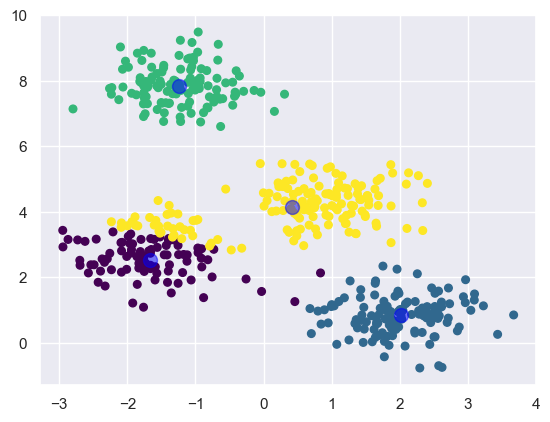

In [6]:
centroids, clusters = kmeans(X, k=4)
row_index = [y for x in clusters for y in x]
cluster_no = []
for cluster_idx, indexes in enumerate(clusters):
    for index in indexes:
        cluster_no.append(cluster_idx)
plt.scatter(X[row_index, 0], X[row_index, 1], c= cluster_no, s=30, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=100, alpha=0.5)

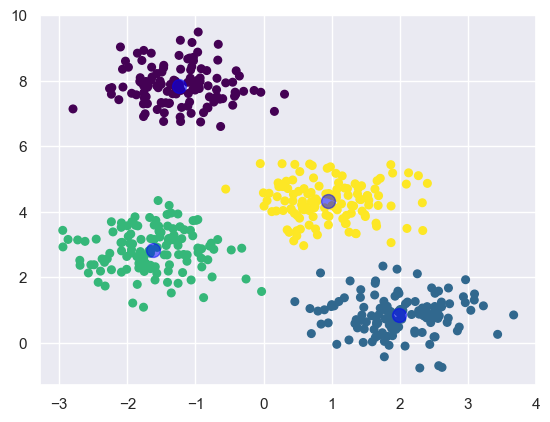

In [8]:
centroids, clusters = kmeans(X, k=4, centroids='kmeans++')
row_index = [y for x in clusters for y in x]
cluster_no = []
for cluster_idx, indexes in enumerate(clusters):
    for index in indexes:
        cluster_no.append(cluster_idx)
plt.scatter(X[row_index, 0], X[row_index, 1], c= cluster_no, s=30, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=100, alpha=0.5)

Kmeans identifies the centroids and groups together data points on the basis of some similarity measure (euclidian distance in this case).

Also, we see that there is randomness associated with how kmeans/kmeans++ selects clusters. Every iteration gives us slightly different results.

### Some fun stuff -> Kmeans for Image compression

Kmeans can also be used to compress images by bringing down the number of colours used.

Let's take a look at image compression using kmeans on  a cool and candid photo of our Professor, Mustafa Hajij.

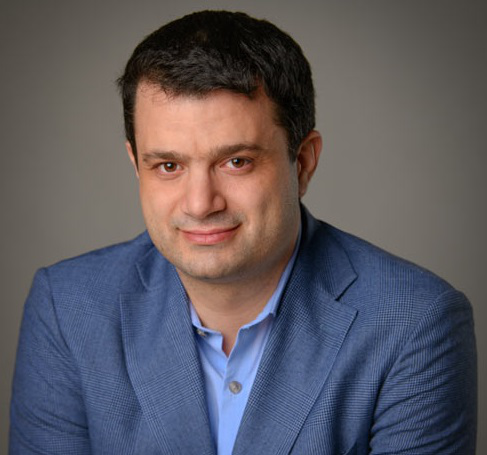

In [9]:
path = 'images/hajij.jpg'
Image.open(path)

Now lets see the shape of these images.

In [10]:
im = Image.open(path)
#im = im.convert('L')
np_im = np.array(im)
print(np_im.shape)

(455, 487, 3)


An image is represented as 3 seperate matrices for colours Red / Blue / Green and their contributions are stored as integers from 0 to 255.

In [11]:
np.max(np.max(np_im, axis=1), axis=0)

array([249, 200, 255], dtype=uint8)

I will convert it into grey scale for ease of use. Also, its required to reshape the image matrix into a 2-D array.

In [12]:
data = np_im.reshape(np_im.shape[0] * np_im.shape[1],np_im.shape[2]) #/ 255 ## rescale 0-255 to 0-1
data.shape

(221585, 3)

We see that there are a total of > 500,000 colours used to describe this image. Lets reduce it down to 10 colours and see how that looks.

In [13]:
k = 10
centroids, clusters = kmeans(data, k=k, centroids='kmeans++')

In [14]:
## get transformed matrix for image
new_colours = data.copy()
for cluster_no, row_indexes in enumerate(clusters):
    new_colours[row_indexes, :] = centroids[cluster_no]

Text(0.5, 1.0, '10-color Image')

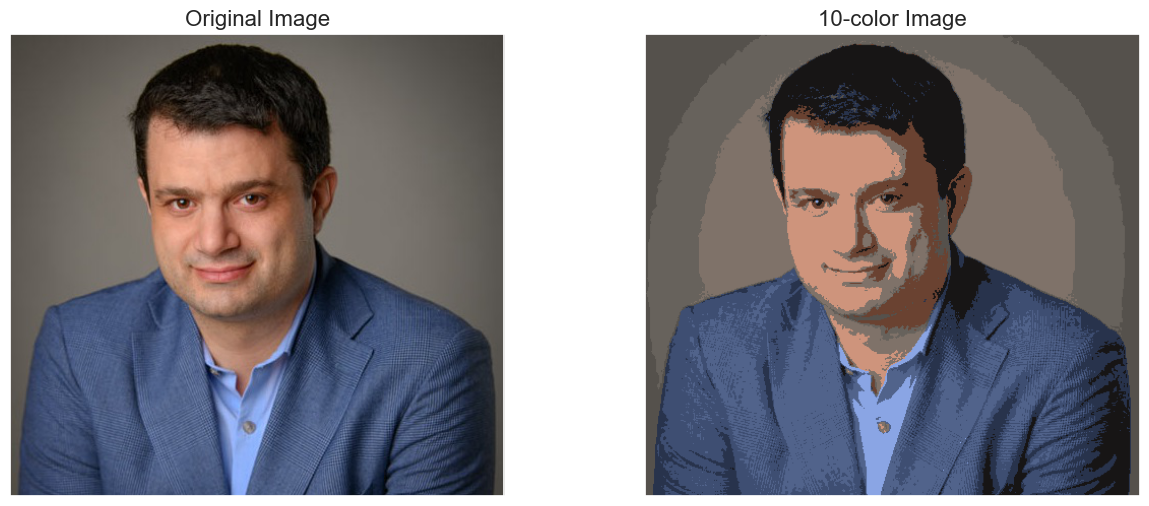

In [15]:
## plot recoloured and original image
im_recolored = new_colours.reshape(np_im.shape)
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(im)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(im_recolored)
ax[1].set_title(f'{k}-color Image', size=16)

Also lets change the no of colours ( i.e. clusters) and see how the image looks like.

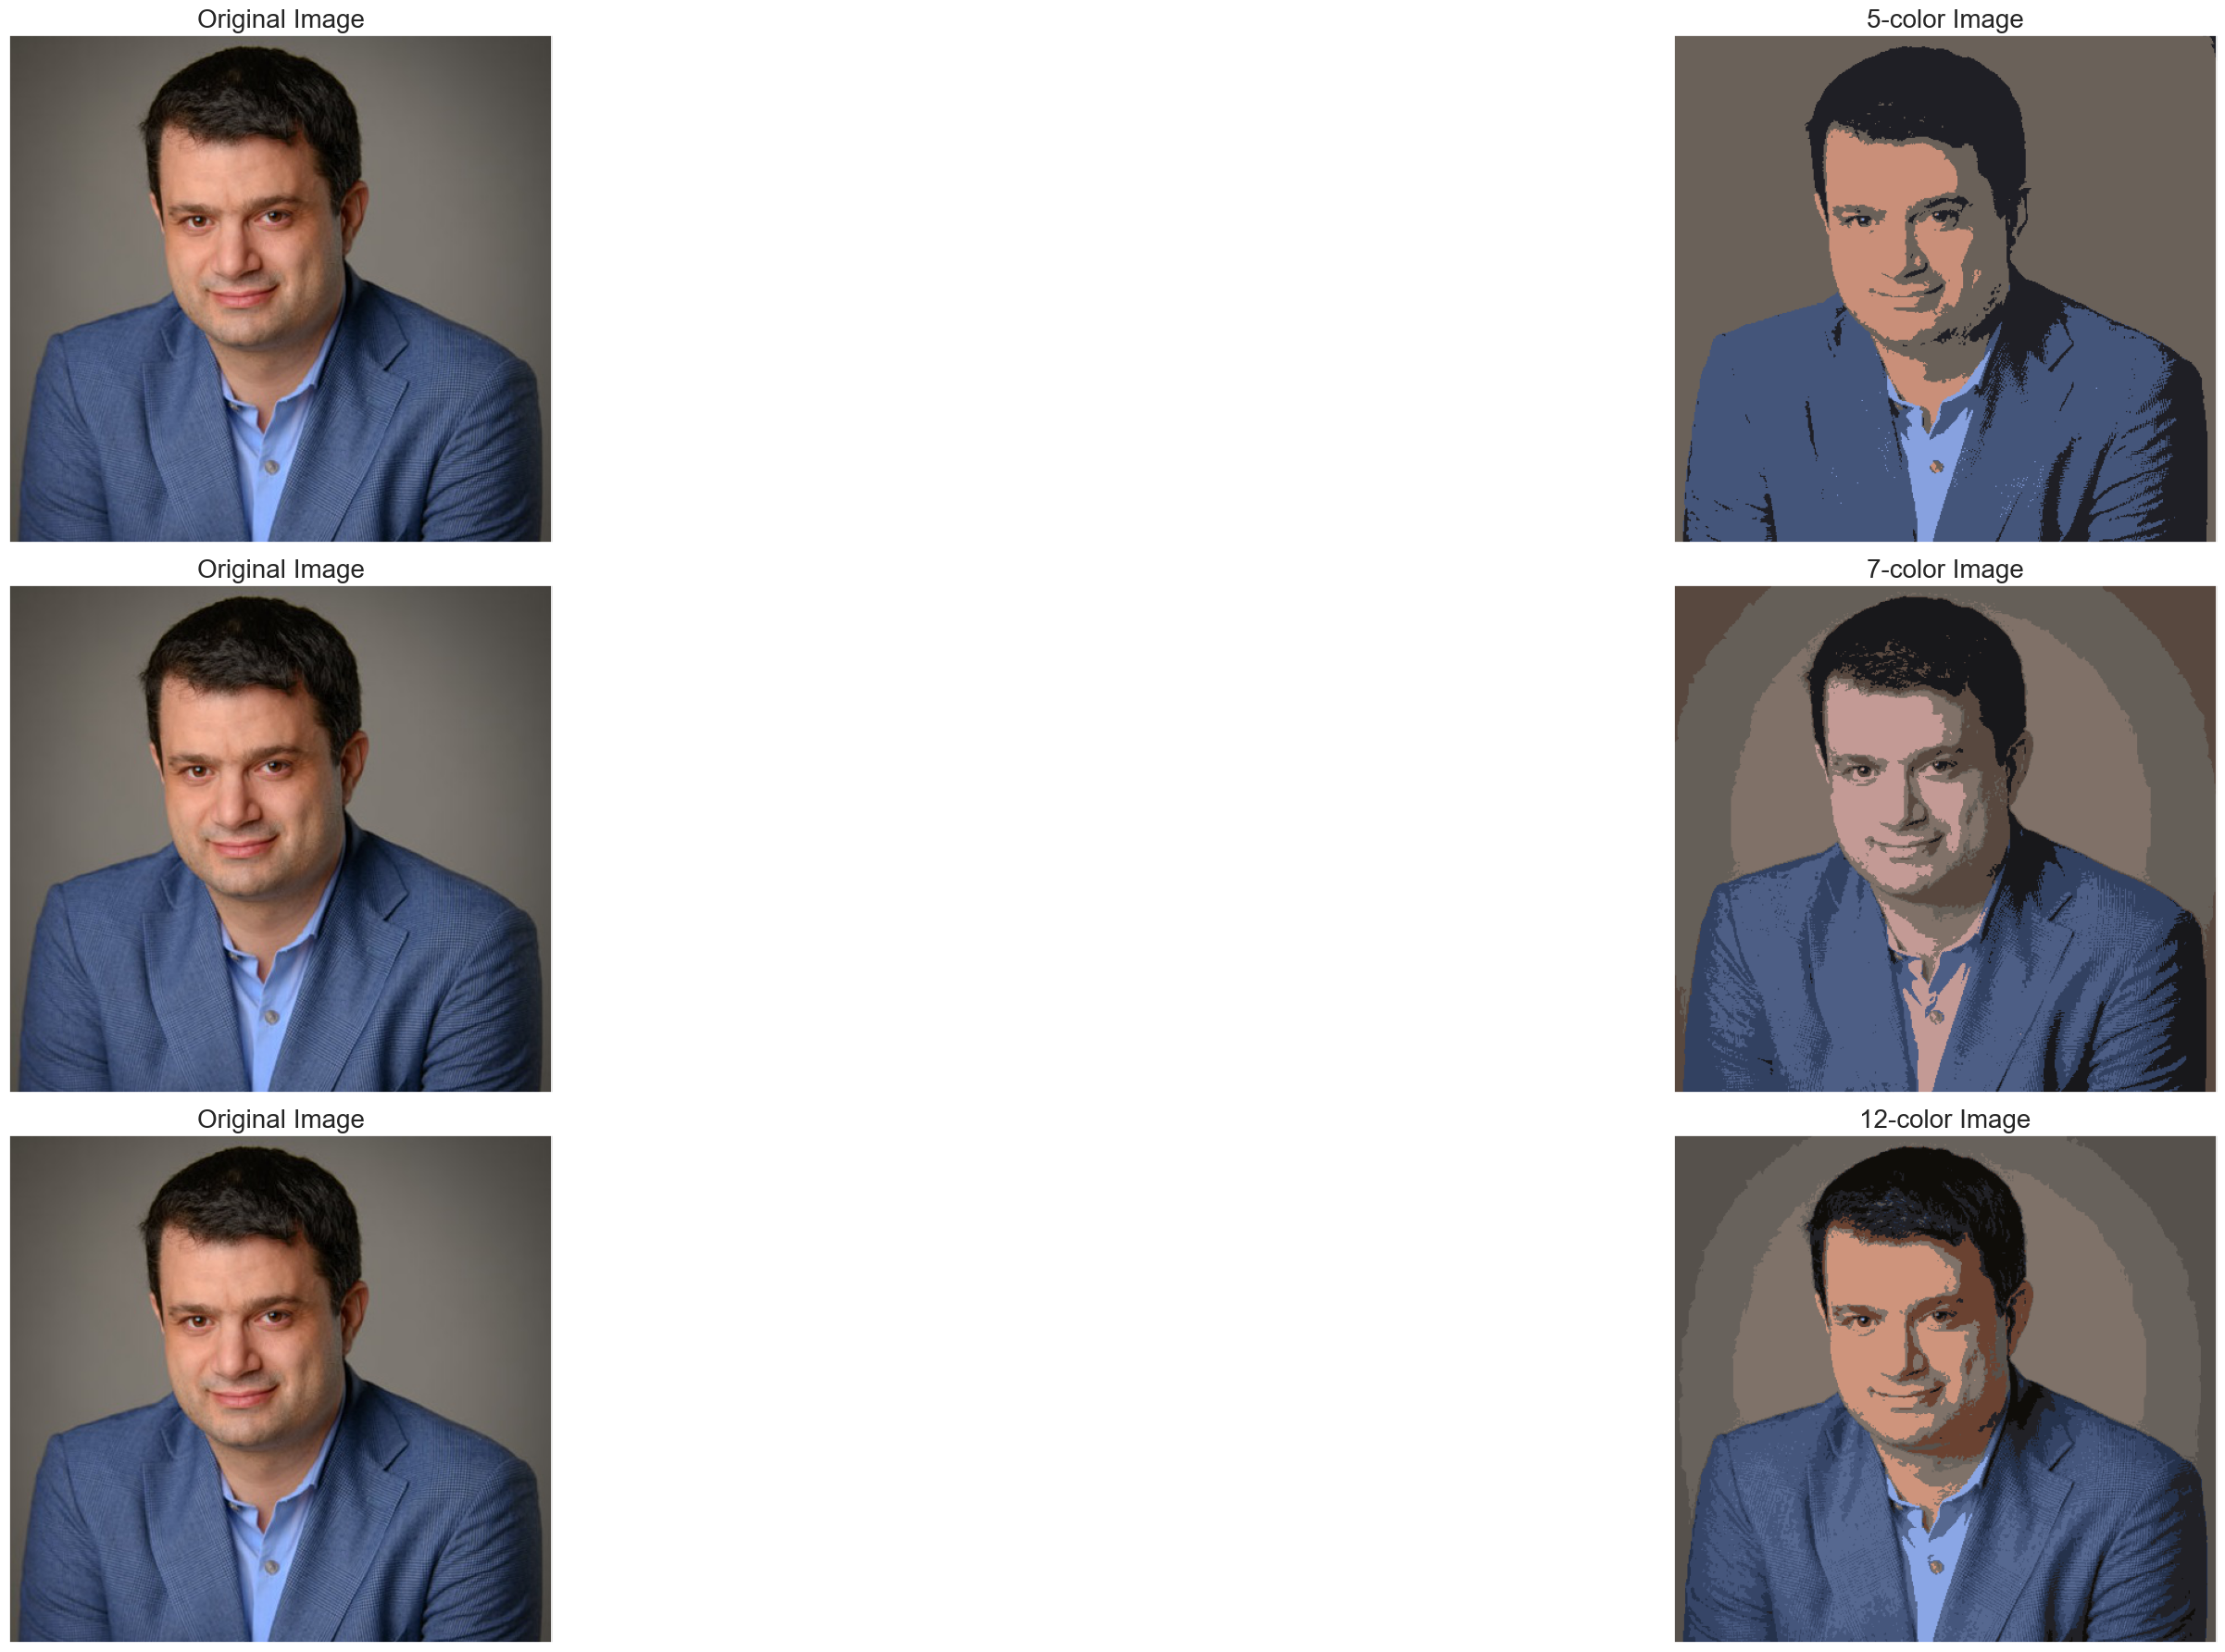

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(60, 18), subplot_kw=dict(xticks=[], yticks=[]))
for idx, no_colours in enumerate([5,7,12]):
    centroids, clusters = kmeans(data, k=no_colours, centroids='kmeans++')
    new_colours = data.copy()
    for cluster_no, row_indexes in enumerate(clusters):
        new_colours[row_indexes, :] = centroids[cluster_no]
    im_recolored = new_colours.reshape(np_im.shape)
    ax[idx, 0].imshow(im)
    ax[idx, 0].set_title('Original Image', size=20)
    ax[idx, 1].imshow(im_recolored)
    ax[idx, 1].set_title(f'{no_colours}-color Image', size=20)
    plt.tight_layout()

### Spectral Clustering

Spectral Clustering is a machine learning algorithm used for clustering data points that are not linearly separable. It is based on the concept of graph theory and spectral decomposition of a matrix. Spectral Clustering can be used when other traditional clustering algorithms such as K-Means or Hierarchical Clustering fail to identify clusters with non-linear boundaries.

In Spectral Clustering, the data points are first represented as a similarity graph, where the nodes represent the data points and the edges between the nodes represent the similarity or dissimilarity between the data points. The similarity between the data points is measured using a kernel function, such as the Gaussian kernel or Laplacian kernel.

Once the similarity graph is constructed, Spectral Clustering proceeds to partition the graph into k clusters. This is done by finding the k eigenvectors of the graph Laplacian matrix, where k is the number of clusters. The Laplacian matrix of the graph is constructed as the difference between the degree matrix and the adjacency matrix of the graph. The degree matrix represents the sum of weights of the edges connected to each node, while the adjacency matrix represents the weights of the edges between nodes.

After obtaining the k eigenvectors of the Laplacian matrix, they are used to form a new matrix, where each data point is represented by a row in this matrix. The rows of this matrix are then clustered using K-Means or other clustering algorithms.

The key advantage of Spectral Clustering is that it can identify clusters with complex boundaries, even when the data points are not linearly separable. Spectral Clustering is also very flexible as it can work with different types of similarity measures, such as the Gaussian kernel, Laplacian kernel, or other similarity measures.

However, Spectral Clustering also has some disadvantages. It requires computing the eigenvalues and eigenvectors of the Laplacian matrix, which can be computationally expensive, especially for large datasets. In addition, Spectral Clustering requires the number of clusters k to be specified in advance, which can be difficult if the number of clusters is not known a priori.

Pseudocode Spectral Clustering :

Input: 
- X: dataset of n points
- k: number of clusters
- sigma: bandwidth parameter for Gaussian kernel

1. Compute the similarity graph which *adjacency matrix* using Gaussian kernels/K-neighbor distances/radius neighbor distances.

2. Compute the Graph Laplacian matrix L for the similarity graph.

4. Compute the spectral embedding by spectral decomposition of the Laplacian.

5. Perform Cluster analysis of the Spectral Embedding via Kmeans or similar algorithms.

Output:
- A list of cluster assignments for each data point


Here's an implementation of it with numpy and Kmeans.

In [17]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from sklearn.cluster import KMeans

def spectral_clustering(X, n_clusters, sigma=1):
    

    A = radius_neighbors_graph(X ,0.4,mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
    # A = kneighbors_graph(X_mn, 2, mode='connectivity', metric='minkowski', p=2, metric_params=None, include_self=False)
    A = A.toarray()
    L = csgraph.laplacian(A, normed=False)
    

    eigval, eigvec = np.linalg.eig(L)
    
    #Assigning Clusters
    #if eig_val(x) = +ve --> cluster 1
    #if eig_val(x) = -ve --> cluster 0

    y_spec =eigvec[:,1].copy()
    y_spec[y_spec < 0] = 0
    y_spec[y_spec > 0] = 1
    return y_spec



The time complexity of Spectral Clustering algorithm depends on the number of data points n, the number of clusters k, and the method used to compute the eigenvectors. A naive implementation of Spectral Clustering has a time complexity of O(n^3) for computing the full Laplacian matrix and O(n^2) for computing the similarity matrix. However, there are faster algorithms such as the Lanczos algorithm that can be used to compute the top k eigenvectors with a time complexity of O(n * k^2), making Spectral Clustering more feasible for large datasets.

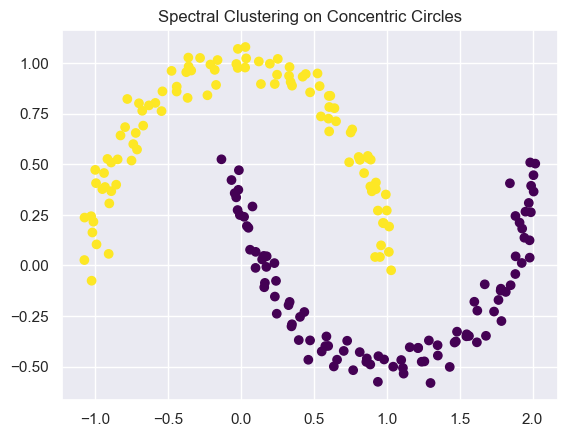

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate dataset of concentric circles with noise
X, y = make_moons(200, noise=.05, random_state=0)

# Apply spectral clustering to dataset
labels = spectral_clustering(X, n_clusters=2)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('Spectral Clustering on Concentric Circles')
plt.show()


### Kmeans vs Spectral Clustering

Kmeans is limited to linear cluster boundaries. Lets see how it performs for clusters with non linear boundaries. We will be using the sklearn modules and models provided in the package.

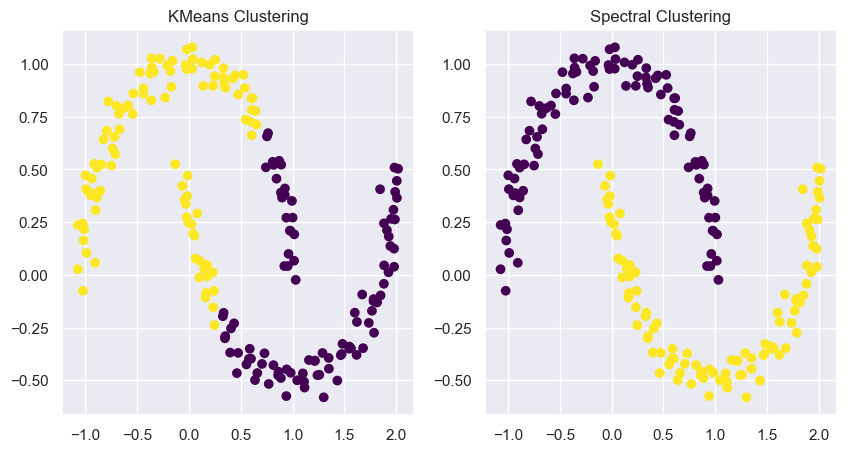

In [19]:
# Generate dataset of concentric circles with noise
# X, y = make_circles(n_samples=1000, noise=0.05, factor=0.5)
X, y = make_moons(200, noise=.05, random_state=0)

# Create KMeans object with 2 clusters and fit to data
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

# Create SpectralClustering object with 2 clusters and fit to data
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
spectral.fit(X)

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot KMeans results
axs[0].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
axs[0].set_title('KMeans Clustering')

# Plot Spectral Clustering results
axs[1].scatter(X[:, 0], X[:, 1], c=spectral.labels_, cmap='viridis')
axs[1].set_title('Spectral Clustering')

plt.show()

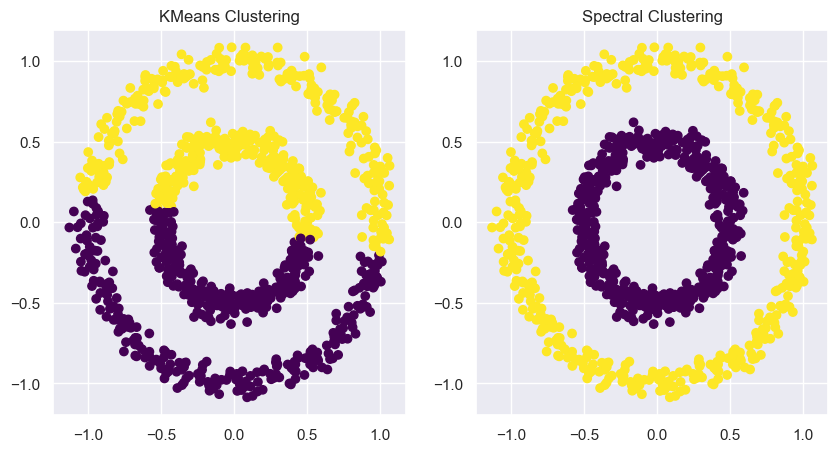

In [20]:
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt

# Generate dataset of concentric circles with noise
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.5)

# Create KMeans object with 2 clusters and fit to data
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

# Create SpectralClustering object with 2 clusters and fit to data
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
spectral.fit(X)

# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot KMeans results
axs[0].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
axs[0].set_title('KMeans Clustering')

# Plot Spectral Clustering results
axs[1].scatter(X[:, 0], X[:, 1], c=spectral.labels_, cmap='viridis')
axs[1].set_title('Spectral Clustering')

plt.show()

This demonstrates that KMeans clustering struggles to separate the concentric circles, while Spectral Clustering is able to separate them effectively. This is because KMeans assumes that clusters are spherical and equally sized, which is not the case for the concentric circles data or the moons data.

Spectral Clustering, on the other hand, is able to capture the nonlinear structure of the dataset using the eigenvectors of the similarity matrix. Kernel Methods that project data onto a higher dimension work much better for such non-linearly seperable datasets.